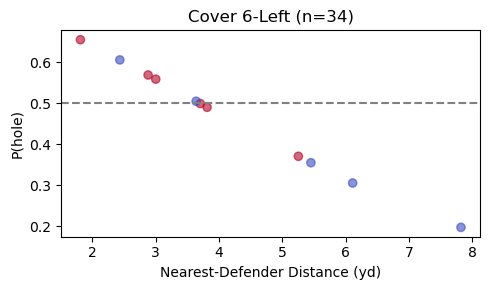

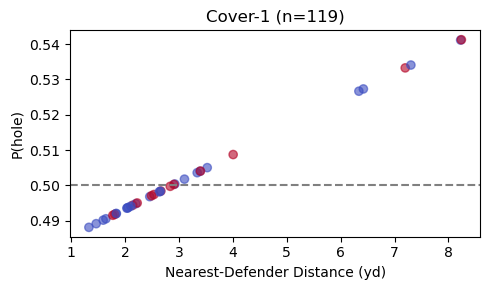

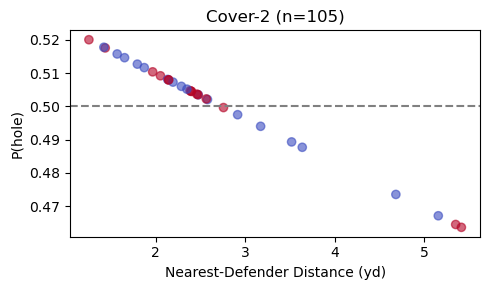

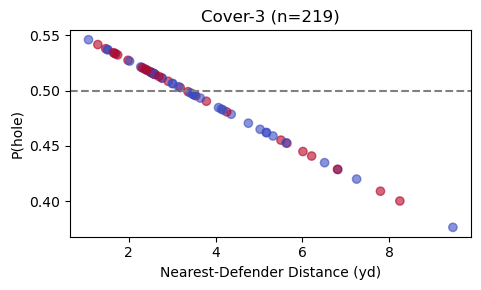

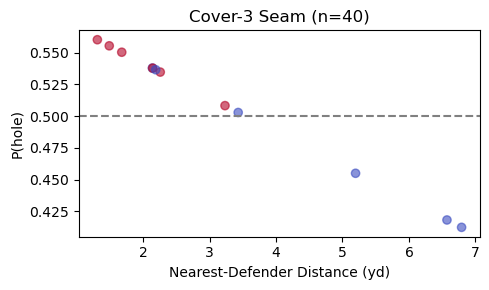

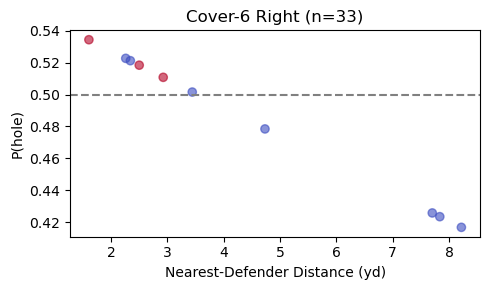

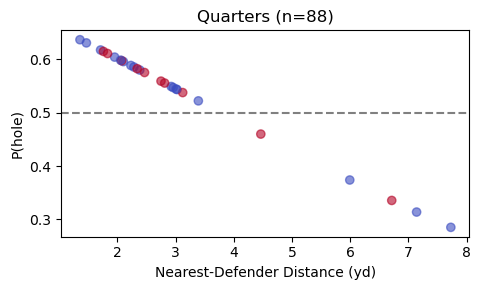


Performance by Coverage:
               n_samples  precision  recall  f1_score    AUC
coverage                                                    
Cover 6-Left          34      0.600   0.500     0.545  0.733
Cover-1              119      0.357   0.385     0.370  0.589
Cover-2              105      0.522   0.800     0.632  0.518
Cover-3              219      0.528   0.633     0.576  0.564
Cover-3 Seam          40      0.667   1.000     0.800  0.861
Cover-6 Right         33      0.500   1.000     0.667  0.810
Quarters              88      0.364   0.800     0.500  0.482


In [6]:

import os
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# data folder
BASE_PATH = "nfl-big-data-bowl-2025/"

#Load CSVs
tracking    = pd.read_csv(os.path.join(BASE_PATH, "tracking_week_1.csv"))
player_play = pd.read_csv(os.path.join(BASE_PATH, "player_play.csv"))
plays       = pd.read_csv(os.path.join(BASE_PATH, "plays.csv"))

# 3) Identify the coverage‐scheme column dynamically
cov_cols = [c for c in plays.columns if "cover" in c.lower()]
if not cov_cols:
    raise KeyError("No coverage column found in plays.csv")
cov_col = cov_cols[0] 

#Build receptions + YAC
recs = (
    player_play
    .query("hadPassReception == 1 and yardageGainedAfterTheCatch.notnull()")
    [["gameId","playId","nflId","yardageGainedAfterTheCatch"]]
    .rename(columns={"yardageGainedAfterTheCatch":"yac"})
)

#Last BEFORE_SNAP per player/play
pre = (
    tracking
    .query("frameType=='BEFORE_SNAP' and nflId.notnull()")
    .sort_values("frameId")
)
pre_last = pre.groupby(["gameId","playId","nflId"], as_index=False).tail(1)

#Merge so we have each targeted receiver at snap + coverage label
df = (
    pre_last
    .merge(recs, on=["gameId","playId","nflId"], how="inner")
    .merge(plays[["gameId","playId", cov_col]], on=["gameId","playId"], how="left")
    .rename(columns={cov_col: "coverage"})
)

#Compute nearest‑defender distance at snap
def compute_nearest(row):
    defs = pre_last[
        (pre_last.gameId == row.gameId) &
        (pre_last.playId == row.playId) &
        (pre_last.nflId != row.nflId)
    ][["x","y"]].to_numpy()
    return np.nan if defs.size == 0 else cKDTree(defs).query([[row.x, row.y]])[0][0]

df["nearest_def_dist"] = df.apply(compute_nearest, axis=1)

#Label “hole” if YAC > 4 yards
df["hole"] = df.yac > 4

#Train & evaluate per coverage
results = []
for cov, grp in df.groupby("coverage"):
    # skip small or single‑class groups
    if len(grp) < 30 or grp.hole.nunique() < 2:
        continue

    X = grp[["nearest_def_dist"]].values
    y = grp["hole"].astype(int).values

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    clf = LogisticRegression(class_weight="balanced", max_iter=200, random_state=42)
    clf.fit(Xtr, ytr)

    y_pred = clf.predict(Xte)
    y_prob = clf.predict_proba(Xte)[:,1]

    report = classification_report(yte, y_pred, zero_division=0, output_dict=True)
    roc_auc = roc_auc_score(yte, y_prob)

    results.append({
        "coverage": cov,
        "n_samples": len(grp),
        "precision": report["1"]["precision"],
        "recall":    report["1"]["recall"],
        "f1_score":  report["1"]["f1-score"],
        "AUC":   roc_auc
    })

    # scatter plot of P(hole) vs distance
    plt.figure(figsize=(5,3))
    plt.scatter(Xte[:,0], y_prob, c=yte, cmap="coolwarm", alpha=0.6)
    plt.axhline(0.5, linestyle="--", color="gray")
    plt.xlabel("Nearest‑Defender Distance (yd)")
    plt.ylabel("P(hole)")
    plt.title(f"{cov} (n={len(grp)})")
    plt.tight_layout()
    plt.show()

# 10) Summary table
res_df = pd.DataFrame(results).set_index("coverage")
print("\nPerformance by Coverage:")
print(res_df.round(3))


Total merged rows: 1959
open
True     1458
False     501
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       151
           1       0.93      0.70      0.80       150

    accuracy                           0.82       301
   macro avg       0.84      0.82      0.82       301
weighted avg       0.84      0.82      0.82       301

AUC: 0.9285209713024282


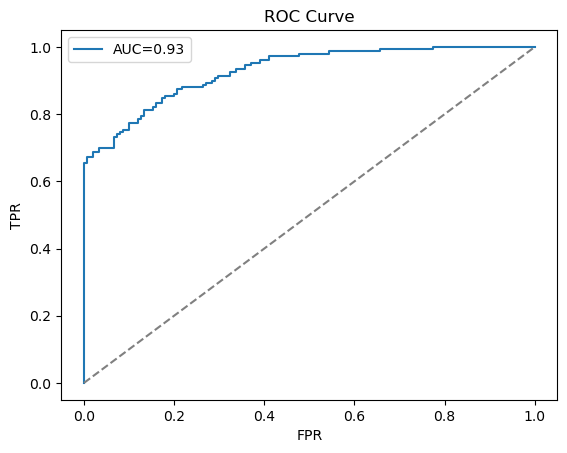

In [7]:
import os
import pandas as pd
import numpy as np                       
from scipy.spatial import cKDTree        
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt          
# datafolder
data_dir = "nfl-big-data-bowl-2025/"
weeks    = [1, 2, 3]                      

#grab csvs
track_list = []
for wk in weeks:
    path = os.path.join(data_dir, f"tracking_week_{wk}.csv")
    track_list.append(
        pd.read_csv(path,
            usecols=["gameId","playId","frameId","x","y","nflId","frameType","event"],
            dtype={
                "gameId":"int32","playId":"int32","frameId":"int32",
                "x":"float32","y":"float32","nflId":"Int32",
                "frameType":"category","event":"category"
            }
        )
    )
tracking = pd.concat(track_list, ignore_index=True)
tracking = tracking.query("nflId.notnull()").astype({"nflId":"int32"})

# pull in the other two tables
pp = pd.read_csv(os.path.join(data_dir, "player_play.csv"))
plays = pd.read_csv(os.path.join(data_dir, "plays.csv"))

#find receptions, snap, and catch frames
receptions = pp.query("hadPassReception==1")[["gameId","playId","nflId"]]

snap = (
    tracking
    .query("frameType=='BEFORE_SNAP'")
    .sort_values("frameId")
    .groupby(["gameId","playId","nflId"], as_index=False)
    .tail(1)
    .rename(columns={"x":"x_snap","y":"y_snap"})
)

catch_arr = (
    tracking
    .query("event=='pass_arrived'")
    .sort_values("frameId")
    .groupby(["gameId","playId","nflId"], as_index=False)
    .first()[["gameId","playId","nflId","x","y","frameId"]]
    .rename(columns={"x":"x_catch","y":"y_catch","frameId":"frame_catch"})
)

df = (receptions
      .merge(snap, on=["gameId","playId","nflId"])
      .merge(catch_arr, on=["gameId","playId","nflId"]))
print("Total merged rows:", len(df))

# find nearest defender
def knearest(px, py, pts):
    if pts.size == 0:
        return np.nan
    return cKDTree(pts).query([[px,py]])[0][0]

#compute distances at snap and catch
df["dist_snap"]  = df.apply(lambda r: knearest(
    r.x_snap, r.y_snap,
    snap[
        (snap.gameId==r.gameId)&
        (snap.playId==r.playId)&
        (snap.nflId!=r.nflId)
    ][["x_snap","y_snap"]].values
), axis=1)

df["dist_catch"] = df.apply(lambda r: knearest(
    r.x_catch, r.y_catch,
    tracking[
        (tracking.gameId==r.gameId)&
        (tracking.playId==r.playId)&
        (tracking.frameId==r.frame_catch)&
        (tracking.nflId!=r.nflId)
    ][["x","y"]].values
), axis=1)

# how much separation was gained
df["sep_gain"] = df["dist_catch"] - df["dist_snap"]

# and how big the hole was at snap
xs = np.arange(0, 121, 5)
ys = np.arange(0, 54, 5)
grid = np.stack(np.meshgrid(xs, ys), -1).reshape(-1, 2)
coord_map = snap.set_index(["gameId","playId"])[["x_snap","y_snap"]].groupby(level=[0,1]).apply(lambda g: g.values).to_dict()

df["snap_hole"] = df.apply(
    lambda r: cKDTree(coord_map[(r.gameId, r.playId)]).query(grid)[0].max(),
    axis=1
)

# bring in coverage label
cov_col = [c for c in plays.columns if "cover" in c.lower()][0]
df = df.merge(plays[["gameId","playId",cov_col]], on=["gameId","playId"])
df.rename(columns={cov_col:"coverage"}, inplace=True)

# mark open vs closed at catch (sep>=2 yd)
df["open"] = df["dist_catch"] >= 2
print(df.open.value_counts())

#downsample the majority so classes are 1:1
closed = df[df.open==False]
open_  = df[df.open==True].sample(len(closed), random_state=42)
balanced = pd.concat([closed, open_])

# 9) prepare features & labels
X = pd.concat([
    balanced[["dist_snap","sep_gain","snap_hole"]],
    pd.get_dummies(balanced["coverage"], prefix="cov")
], axis=1)
y = balanced["open"].astype(int)

# 10) split & train a small forest
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
forest = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
forest.fit(Xtr, ytr)

# 11) check performance
preds = forest.predict(Xte)
probs = forest.predict_proba(Xte)[:,1]
print(classification_report(yte, preds, zero_division=0))
print("AUC:", roc_auc_score(yte, probs))

# 12) draw the ROC curve
fpr, tpr, _ = roc_curve(yte, probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(yte, probs):.2f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()



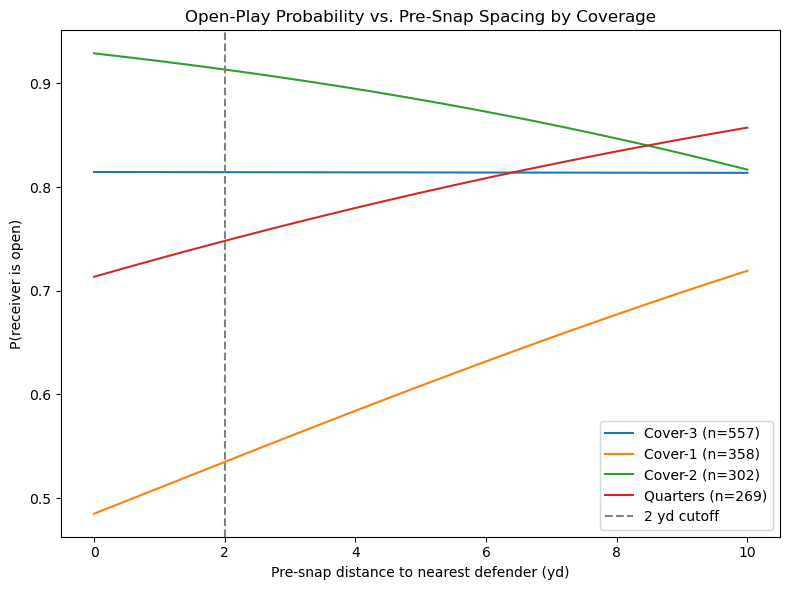

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# datafolder:
DATA_DIR = "nfl-big-data-bowl-2025/"
WEEKS    = [1, 2, 3]

#Load tracking weeks
parts = []
for w in WEEKS:
    fp = os.path.join(DATA_DIR, f"tracking_week_{w}.csv")
    parts.append(pd.read_csv(fp))
track = pd.concat(parts, ignore_index=True)
track = track.query("nflId.notnull()").astype({"nflId":"int32"})

#Load receptions & plays
pp    = pd.read_csv(os.path.join(DATA_DIR, "player_play.csv"))
plays = pd.read_csv(os.path.join(DATA_DIR, "plays.csv"))

#Build pre‑snap (last BEFORE_SNAP) and catch frames
recs     = pp.query("hadPassReception==1")[["gameId","playId","nflId"]]
pre_snap = track.query("frameType=='BEFORE_SNAP'").sort_values("frameId")
last_snap = (
    pre_snap
    .groupby(["gameId","playId","nflId"], as_index=False)
    .tail(1)
    .rename(columns={"x":"x_snap","y":"y_snap"})
)
catch = (
    track.query("event=='pass_arrived'").sort_values("frameId")
         .groupby(["gameId","playId","nflId"], as_index=False).first()
         [["gameId","playId","nflId","x","y","frameId"]]
         .rename(columns={"x":"x_catch","y":"y_catch","frameId":"frame_catch"})
)

df = recs.merge(last_snap, on=["gameId","playId","nflId"]) \
         .merge(catch,     on=["gameId","playId","nflId"])

#nearest‑defender distance
def nearest(px, py, pts):
    return np.nan if pts.size==0 else cKDTree(pts).query([[px,py]])[0][0]

#Compute pre‑snap spacing
df["dist_snap"] = df.apply(lambda r: nearest(
    r.x_snap, r.y_snap,
    last_snap[
        (last_snap.gameId==r.gameId)&
        (last_snap.playId==r.playId)&
        (last_snap.nflId!=r.nflId)
    ][["x_snap","y_snap"]].to_numpy()
), axis=1)

# Label “open” if catch separation ≥ 2 yd
df["open"] = df.apply(lambda r: nearest(
    r.x_catch, r.y_catch,
    track[
        (track.gameId==r.gameId)&
        (track.playId==r.playId)&
        (track.frameId==r.frame_catch)&
        (track.nflId!=r.nflId)
    ][["x","y"]].to_numpy()
) >= 2, axis=1)

#Merge in coverage label
cov_col = [c for c in plays.columns if "cover" in c.lower()][0]
df = df.merge(plays[["gameId","playId",cov_col]], on=["gameId","playId"])\
       .rename(columns={cov_col:"coverage"})

# pick the top 4 coverages by count
top_cov = df["coverage"].value_counts().nlargest(4).index.tolist()

# Fit a simple logistic for each coverage and plot
plt.figure(figsize=(8,6))
x_grid = np.linspace(0,10,200).reshape(-1,1)

for cov in top_cov:
    sub = df[df["coverage"]==cov]
    X   = sub["dist_snap"].values.reshape(-1,1)
    y   = sub["open"].astype(int).values

    model = LogisticRegression(solver="liblinear")
    model.fit(X, y)

    probs = model.predict_proba(x_grid)[:,1]
    plt.plot(x_grid.flatten(), probs, label=f"{cov} (n={len(sub)})")

# plt
plt.axvline(2, color="gray", linestyle="--", label="2 yd cutoff")
plt.xlabel("Pre‑snap distance to nearest defender (yd)")
plt.ylabel("P(receiver is open)")
plt.title("Open‑Play Probability vs. Pre‑Snap Spacing by Coverage")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
